# Calculate buoyancy frequency profiles, WKB limit and ultimately vertical modes

In [2]:
import sys
sys.path.append("/home/149/ab8992/tasman-tides/")
import xarray as xr
import ttidelib as tt
import scipy
import cmocean
import os
from pathlib import Path
cmap = cmocean.cm.dense_r
import matplotlib
import matplotlib.pyplot as plt
earth_cmap = matplotlib.colormaps["gist_earth"]
from datetime import timedelta
# import filtering
import numpy as np
import dask
from dask.distributed import Client,default_client
import xrft


def startdask():
    try:
    # Try to get the existing Dask client
        client = default_client()
        print(client)
    except ValueError:
        # If there's no existing client, create a new one
        client = Client()
        print(client)
    return client

client = startdask()
client

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43621 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:43105' processes=7 threads=28, memory=112.00 GiB>


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/43621/status,
Dashboard: /proxy/43621/status,Workers: 7
Total threads: 28,Total memory: 112.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43105,Workers: 7
Dashboard: /proxy/43621/status,Total threads: 28
Started: Just now,Total memory: 112.00 GiB
Comm: tcp://127.0.0.1:37313,Total threads: 4
Dashboard: /proxy/38889/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:37533,


## First draft a function to calculate N(z)

$ \large N = \frac{-g}{\rho}\frac{\partial \rho}{\partial z} $


In [5]:
data = tt.collect_data(exptname="full-20",rawdata = ["rho","u"],timerange = (38000 - 10,38000 + 10)).sel(yb = slice(-50,50),xb = slice(700,750))
data.zl

loading rho...	done.
loading u...	done.


<xarray.DataArray 'zl' (zl: 100)>
array([2.703753e+00, 8.125880e+00, 1.357918e+01, 1.906775e+01, 2.459623e+01,
       3.016989e+01, 3.579464e+01, 4.147720e+01, 4.722515e+01, 5.304703e+01,
       5.895252e+01, 6.495250e+01, 7.105930e+01, 7.728676e+01, 8.365052e+01,
       9.016818e+01, 9.685954e+01, 1.037469e+02, 1.108551e+02, 1.182124e+02,
       1.258502e+02, 1.338036e+02, 1.421120e+02, 1.508192e+02, 1.599741e+02,
       1.696308e+02, 1.798495e+02, 1.906965e+02, 2.022449e+02, 2.145749e+02,
       2.277741e+02, 2.419380e+02, 2.571697e+02, 2.735803e+02, 2.912884e+02,
       3.104201e+02, 3.311080e+02, 3.534903e+02, 3.777098e+02, 4.039118e+02,
       4.322427e+02, 4.628474e+02, 4.958665e+02, 5.314341e+02, 5.696743e+02,
       6.106986e+02, 6.546025e+02, 7.014638e+02, 7.513394e+02, 8.042643e+02,
       8.602503e+02, 9.192855e+02, 9.813352e+02, 1.046342e+03, 1.114229e+03,
       1.184899e+03, 1.258243e+03, 1.334134e+03, 1.412441e+03, 1.493021e+03,
       1.575730e+03, 1.660421e+03, 1.746950e+03, 1.835173e+03, 1.924952e+03,
       2.016155e+03, 2.108655e+03, 2.202334e+03, 2.297081e+03, 2.392793e+03,
       2.489374e+03, 2.586736e+03, 2.684800e+03, 2.783492e+03, 2.882746e+03,
       2.982502e+03, 3.082706e+03, 3.183309e+03, 3.284266e+03, 3.385539e+03,
       3.487093e+03, 3.588895e+03, 3.690919e+03, 3.793138e+03, 3.895532e+03,
       3.998079e+03, 4.100762e+03, 4.203566e+03, 4.306477e+03, 4.409483e+03,
       4.512572e+03, 4.615735e+03, 4.718963e+03, 4.822249e+03, 4.925586e+03,
       5.028969e+03, 5.132391e+03, 5.235849e+03, 5.339337e+03, 5.442854e+03])
Coordinates:
  * zl       (zl) float64 2.704 8.126 13.58 ... 5.236e+03 5.339e+03 5.443e+03
Attributes:
    _FillValue:  nan
    units:       meters
    long_name:   Depth at cell center
    axis:        Z
    positive:    down
    edges:       z_i

In [17]:
data.zl

<xarray.DataArray 'zl' (zl: 100)>
array([2.703753e+00, 8.125880e+00, 1.357918e+01, 1.906775e+01, 2.459623e+01,
       3.016989e+01, 3.579464e+01, 4.147720e+01, 4.722515e+01, 5.304703e+01,
       5.895252e+01, 6.495250e+01, 7.105930e+01, 7.728676e+01, 8.365052e+01,
       9.016818e+01, 9.685954e+01, 1.037469e+02, 1.108551e+02, 1.182124e+02,
       1.258502e+02, 1.338036e+02, 1.421120e+02, 1.508192e+02, 1.599741e+02,
       1.696308e+02, 1.798495e+02, 1.906965e+02, 2.022449e+02, 2.145749e+02,
       2.277741e+02, 2.419380e+02, 2.571697e+02, 2.735803e+02, 2.912884e+02,
       3.104201e+02, 3.311080e+02, 3.534903e+02, 3.777098e+02, 4.039118e+02,
       4.322427e+02, 4.628474e+02, 4.958665e+02, 5.314341e+02, 5.696743e+02,
       6.106986e+02, 6.546025e+02, 7.014638e+02, 7.513394e+02, 8.042643e+02,
       8.602503e+02, 9.192855e+02, 9.813352e+02, 1.046342e+03, 1.114229e+03,
       1.184899e+03, 1.258243e+03, 1.334134e+03, 1.412441e+03, 1.493021e+03,
       1.575730e+03, 1.660421e+03, 1.746950e+03, 1.835173e+03, 1.924952e+03,
       2.016155e+03, 2.108655e+03, 2.202334e+03, 2.297081e+03, 2.392793e+03,
       2.489374e+03, 2.586736e+03, 2.684800e+03, 2.783492e+03, 2.882746e+03,
       2.982502e+03, 3.082706e+03, 3.183309e+03, 3.284266e+03, 3.385539e+03,
       3.487093e+03, 3.588895e+03, 3.690919e+03, 3.793138e+03, 3.895532e+03,
       3.998079e+03, 4.100762e+03, 4.203566e+03, 4.306477e+03, 4.409483e+03,
       4.512572e+03, 4.615735e+03, 4.718963e+03, 4.822249e+03, 4.925586e+03,
       5.028969e+03, 5.132391e+03, 5.235849e+03, 5.339337e+03, 5.442854e+03])
Coordinates:
  * zl       (zl) float64 2.704 8.126 13.58 ... 5.236e+03 5.339e+03 5.443e+03
Attributes:
    _FillValue:  nan
    units:       meters
    long_name:   Depth at cell center
    axis:        Z
    positive:    down
    edges:       z_i

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in sqrt
  return func(*(_execute_task(a, cache) for a in args))


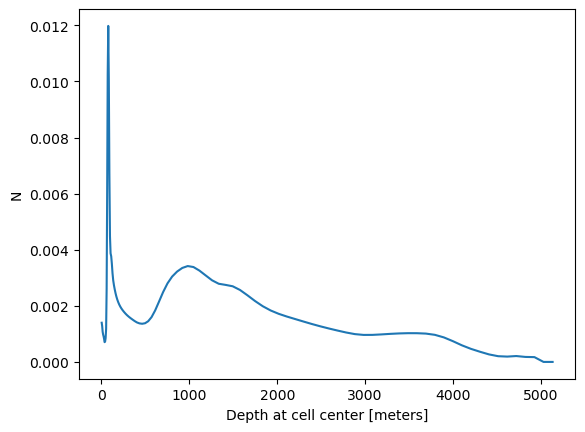

In [15]:
def N(rho):
    """
    Calculate the buoyancy frequency given density rho in z* coords"""
    N = np.sqrt(
        ((9.8 / rho) * rho.differentiate("zl"))
        ).rename("N")
    N.attrs = {"units":"s^-1"}
    return N

N(data).mean("time").mean("xb").mean("yb").plot()